In [1]:
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from subprocess import check_output
from numpy import newaxis
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import tweepy
from tweepy import OAuthHandler
import csv

%matplotlib inline

Using TensorFlow backend.
C:\Users\bobal\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import time

In [3]:
nyse = pd.read_csv('500.csv', skipfooter=2, engine = 'python')

In [12]:
nyse = nyse.rename(columns={'ï»¿"Date"':'Date'})

In [21]:
nyse.head()

,Price,Open,High,Low,Vol.,Change %
21,"2,644.00",2640.75,2650.75,2605.0,252,-0.15
22,"2,658.88",2659.12,2663.00,2655.5,0,0.56


In [45]:
nyse.dtypes

Date         object
Price        object
Open        float64
High        float64
Low         float64
Vol.         object
Change %    float64
dtype: object

In [14]:
import re
nyse['Vol.'] = nyse['Vol.'].apply(lambda x: re.sub("[^0-9]", "", x))

In [7]:
nyse['Open'] = nyse['Open'].astype(float)

In [17]:
nyse.reset_index(drop=True, inplace=True)

In [18]:

nyse.shape

(23, 6)

In [29]:
delta = []
for row in nyse.values:
    delta.append(np.round((float(row[1]) - float(row[0]))/float(row[0])*100,2))

In [32]:
nyse['delta'] = np.round(delta,4)

In [35]:
(nyse[nyse['delta'] >= 1.0].count()/nyse.count()) * 100

Open      4.829545
Close     4.829545
Volume    4.829545
delta     4.829545
dtype: float64

In [36]:
nyse[nyse['delta'] >= 1.0]

,Open,Close,Volume,delta
Date,,,,
2016-01-14,1891.68,1921.84,"920,305,000",1.59
2016-01-22,1877.40,1906.90,"809,147,000",1.57
2016-01-23,1877.40,1906.90,"809,147,000",1.57
2016-01-24,1877.40,1906.90,"809,147,000",1.57
2016-01-26,1878.79,1903.63,"695,956,000",1.32
2016-01-29,1894.00,1940.24,"1,218,351,000",2.44
2016-01-30,1894.00,1940.24,"1,218,351,000",2.44
2016-01-31,1894.00,1940.24,"1,218,351,000",2.44
2016-02-12,1833.40,1864.78,"803,669,000",1.71


Text(0,0.5,'SPY')

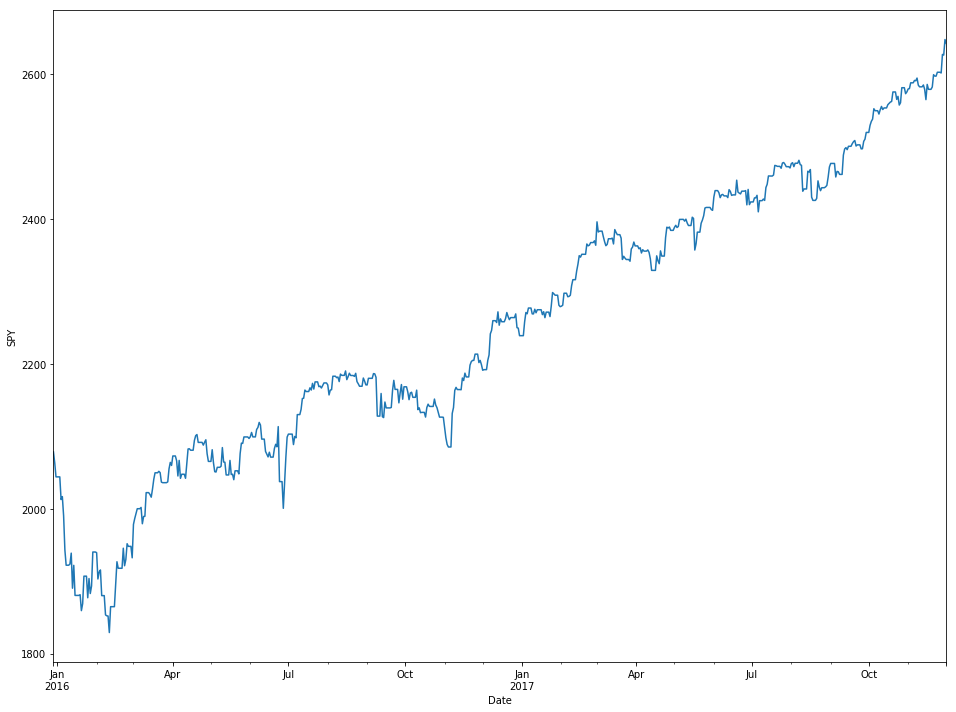

In [39]:
nyse['Close'].plot(figsize=(16, 12))
plt.ylabel('SPY')


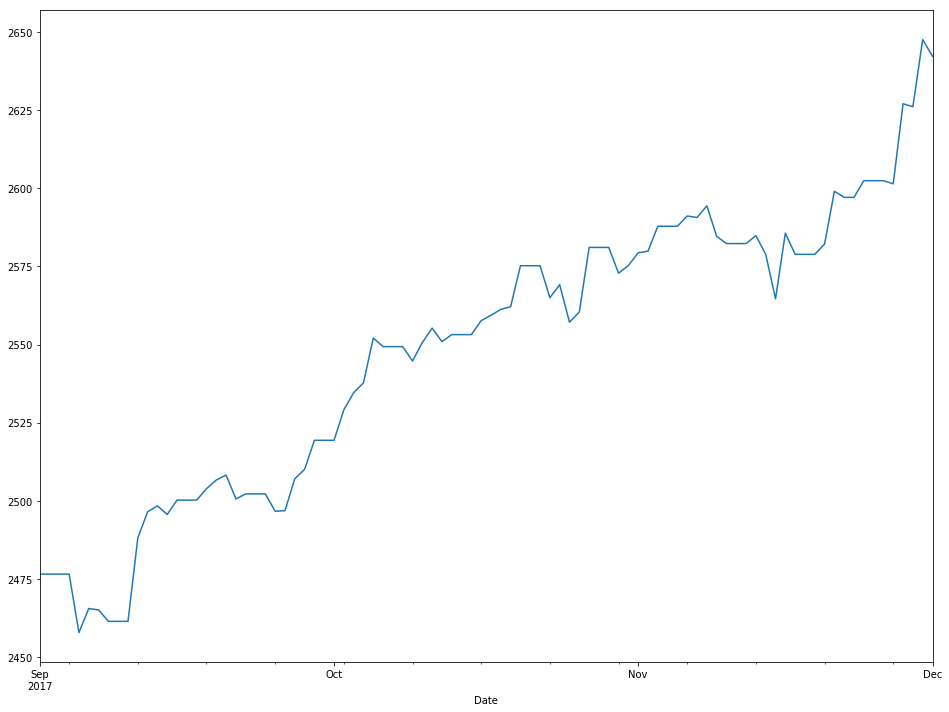

In [41]:
nyse['Close'].truncate(before='2017-09-01').plot(figsize=(16, 12))

In [37]:
nyse[-30:]

,Open,Close,Volume,delta
Date,,,,
2017-11-02,2579.46,2579.85,"2,416,738,000",0.02
2017-11-03,2581.93,2587.84,"2,052,553,000",0.23
2017-11-04,2581.93,2587.84,"2,052,553,000",0.23
2017-11-05,2581.93,2587.84,"2,052,553,000",0.23
2017-11-06,2587.47,2591.13,"2,116,417,000",0.14
2017-11-07,2592.11,2590.64,"2,089,737,000",-0.06
2017-11-08,2588.71,2594.38,"2,092,333,000",0.22
2017-11-09,2584.00,2584.62,"2,233,489,000",0.02
2017-11-10,2580.18,2582.30,"2,045,162,000",0.08


In [41]:
nyse['delta'].max()

2.4161959345235697

In [50]:
nyse['10_day'] = nyse['Close'].rolling(10, center=False).mean()

In [51]:
nyse['30_day'] = nyse['Close'].rolling(30, center=False).mean()

In [52]:
nyse['200_day'] = nyse['Close'].rolling(200, center=False).mean()

In [6]:
# scale data for sigmoid and tanh
nyse= nyse.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
nyse  = scaler.fit_transform(nyse)

C:\Users\bobbyd\Anaconda2\envs\neural_net\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [54]:
nyse.fillna(0, axis=1, inplace=False)

,Close,Volume,delta,10_day,30_day,200_day
Date,,,,,,
2015-12-29,2078.36,"379,027,000",0.000000,0.000,0.000000,0.00000
2015-12-30,2063.36,"334,631,000",-0.726970,0.000,0.000000,0.00000
2015-12-31,2043.94,"482,596,000",-0.950126,0.000,0.000000,0.00000
2016-01-01,2043.94,"482,596,000",0.000000,0.000,0.000000,0.00000
2016-01-02,2043.94,"482,596,000",0.000000,0.000,0.000000,0.00000
2016-01-03,2043.94,"482,596,000",0.000000,0.000,0.000000,0.00000
2016-01-04,2012.66,"802,072,000",-1.554162,0.000,0.000000,0.00000
2016-01-05,2016.71,"619,260,000",0.200822,0.000,0.000000,0.00000
2016-01-06,1990.26,"734,820,000",-1.328972,0.000,0.000000,0.00000


In [7]:
#train test split
train_size = int(len(nyse) * .67)
test_size = len(nyse) - train_size
train, test = nyse[0:train_size,:], nyse[train_size:len(nyse),:]
print(len(train),len(test))

404 199


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
look_back =1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0], 1, testX.shape[1]))

In [11]:
trainX.shape

(402, 1, 1)

In [12]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX,trainY, epochs=100, batch_size=1, verbose =2)

Epoch 1/100
1s - loss: 0.0587
Epoch 2/100
0s - loss: 0.0143
Epoch 3/100
0s - loss: 0.0094
Epoch 4/100
0s - loss: 0.0051
Epoch 5/100
0s - loss: 0.0022
Epoch 6/100
0s - loss: 8.5018e-04
Epoch 7/100
0s - loss: 4.8110e-04
Epoch 8/100
0s - loss: 4.4710e-04
Epoch 9/100
0s - loss: 4.4500e-04
Epoch 10/100
0s - loss: 4.4527e-04
Epoch 11/100
0s - loss: 4.3636e-04
Epoch 12/100
0s - loss: 4.3663e-04
Epoch 13/100
0s - loss: 4.3143e-04
Epoch 14/100
0s - loss: 4.3417e-04
Epoch 15/100
0s - loss: 4.4644e-04
Epoch 16/100
0s - loss: 4.3066e-04
Epoch 17/100
0s - loss: 4.3358e-04
Epoch 18/100
0s - loss: 4.3315e-04
Epoch 19/100
0s - loss: 4.2871e-04
Epoch 20/100
0s - loss: 4.2986e-04
Epoch 21/100
0s - loss: 4.3052e-04
Epoch 22/100
0s - loss: 4.2476e-04
Epoch 23/100
0s - loss: 4.2657e-04
Epoch 24/100
0s - loss: 4.1947e-04
Epoch 25/100
0s - loss: 4.1292e-04
Epoch 26/100
0s - loss: 4.1657e-04
Epoch 27/100
0s - loss: 4.2454e-04
Epoch 28/100
0s - loss: 4.2869e-04
Epoch 29/100
0s - loss: 4.0630e-04
Epoch 30/100
0

In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.42 RMSE
Test Score: 17.87 RMSE


In [195]:
trainY.shape

(1, 297)

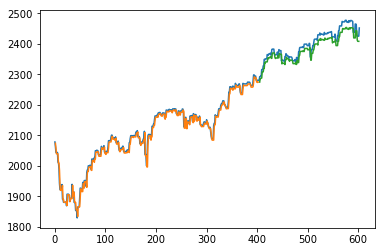

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(nyse)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(nyse)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(nyse)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(nyse))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()